In [182]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score, cross_val_predict, LeaveOneOut, KFold
from sklearn.svm import SVC
from hypopt import GridSearch

from sklearn.preprocessing import OneHotEncoder

from umap import UMAP
import skdim
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
model_path = "/neurospin/dico/jchavas/Runs/70_self-supervised_two-regions/Output/ORBITAL_BT/20-56-02_2"
ukb_emb_file = f"{model_path}/ukb_random_embeddings/full_embeddings.csv"
schiz_emb_file = f"{model_path}/schiz_extended_random_embeddings/full_embeddings.csv"
schiz_path = "/neurospin/dico/data/deep_folding/current/datasets/schiz_extended"
schiz_label_file = f"{schiz_path}/used_schiz_subjects.csv"
train_file = f"{schiz_path}/train_subjects.csv"
val_file = f"{schiz_path}/val_subjects.csv"
test_intra_file = f"{schiz_path}/test_intra_subjects.csv"
test_file = f"{schiz_path}/test_subjects.csv"
precatatoes_file = "/neurospin/dico/data/bv_databases/human/partially_labeled/orbital_patterns/PreCatatoes/OFC_sulcal_type_data_186-subjects_only-schiz-and-control.csv"

In [4]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,1.497522,-17.298222,-7.023603,-11.205885,14.206353,-8.073137,12.077803,1.188005,-21.182160,12.422483,...,-0.782009,-13.568072,11.335606,27.711756,1.055951,16.339926,-6.282044,17.143698,-42.953117,-9.542476
sub-1000458,-3.609246,11.989327,3.261152,-24.368643,17.229946,-15.242127,18.376665,5.099380,-12.348334,1.510425,...,-5.986905,5.410737,-0.495618,18.814777,-1.137268,-2.769095,-3.145500,-1.589806,-26.272230,19.650710
sub-1000575,9.973359,-0.526970,-16.491266,-6.800225,13.853608,-1.892061,12.505042,25.941790,20.332819,6.928286,...,-10.767097,8.413599,1.047728,5.613638,4.589878,5.264478,-3.590338,-26.656113,3.834120,-3.502216
sub-1000606,38.929436,5.370797,8.908671,10.817114,-36.351353,5.951402,-3.859577,19.411158,-6.009777,8.619954,...,-10.831139,4.726006,-3.820110,15.025682,16.366623,-1.969968,30.462904,10.683294,9.435775,28.027756
sub-1000963,36.624977,6.796172,28.739016,-24.772793,-1.008246,-18.348162,12.348809,0.414275,-4.930811,8.232450,...,-3.167979,20.949572,14.828034,14.677424,1.205625,10.694344,7.305981,6.147270,-15.829991,2.581371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,13.933055,-2.528124,13.587676,13.413878,-1.649166,6.557288,6.679683,4.042784,-5.927331,-2.414733,...,-3.064186,6.123437,1.346105,23.049840,17.548922,6.431029,4.111210,-13.984839,8.037389,-27.171171
sub-6023808,2.091982,-9.837544,-9.529078,1.424691,3.072437,2.858213,11.038856,-8.540625,1.723715,-6.049696,...,-19.180178,3.726936,2.863255,20.683193,26.914165,-17.799795,-2.707847,-6.360041,-4.336803,-9.629988
sub-6023847,21.655308,1.412237,-10.311806,4.494585,1.016458,5.328015,14.061031,6.532976,-20.227161,11.678906,...,-0.438347,3.516693,2.250516,42.720130,-2.343096,4.778626,8.819581,-1.611091,-7.671606,2.956114


In [5]:
schiz_emb = pd.read_csv(schiz_emb_file, index_col=0)
schiz_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
1,16.921219,8.329333,-5.448877,8.851546,-18.398794,-1.857798,-4.444204,5.968267,-0.268014,13.468454,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
10,7.104989,6.120277,-6.829818,15.520238,-9.423983,2.037611,-9.840734,-1.371655,-4.365594,7.463162,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
101,7.613643,13.741054,-5.458344,18.283995,-11.090379,1.277567,-16.423290,8.620923,-5.829747,4.834498,...,18.414259,-6.979292,-10.903244,2.263794,-3.441388,0.857427,7.599483,0.368111,4.802815,10.747945
102,0.553018,-6.550310,-3.587916,-3.521572,1.106154,0.770448,-1.361575,9.963407,-10.554010,8.540568,...,-0.682740,-16.735806,-5.279205,25.003445,-3.214172,7.829488,8.097090,14.799098,-11.242142,13.689691
103,19.427036,-1.774481,-1.347161,-15.931410,7.620186,-3.841706,7.235090,13.103435,-11.743684,7.171596,...,-2.804867,-1.034834,-3.511542,3.032715,4.006164,-7.770681,6.105875,13.935489,-28.347569,11.506606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-st110288_ses-v1,-12.782913,-5.901133,-1.407924,9.509115,0.308689,16.974428,-4.469516,19.019762,-40.655870,3.016918,...,-4.421456,-3.375361,-3.465752,26.781263,38.450360,-21.703518,-5.671064,6.561089,-7.678912,-1.216511
sub-va110289_ses-v1,6.532256,14.376952,5.952120,16.046460,-4.903758,4.059140,0.595604,9.792135,0.489636,4.684096,...,-6.790288,4.971684,-7.461099,25.854273,16.517937,-8.975221,26.504993,-4.094486,29.319670,6.338726
sub-ye110322_ses-v1,-12.242721,2.532474,-0.847486,-12.511105,14.140315,-9.390450,-4.939991,4.159391,11.530051,4.173915,...,-23.518219,-3.301317,-8.264235,24.940355,16.266615,3.291722,10.014540,12.962226,-8.867292,-2.547957


In [6]:
schiz_label = pd.read_csv(schiz_label_file, index_col=0)
schiz_label

,sex,age,diagnosis,study,site
participant_id,,,,,
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas
sub-INV1HXNTXYF,F,18.0,control,BSNIP,Dallas
sub-INV1XCNF4J5,F,25.0,control,BSNIP,Dallas
...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne
184,M,26.0,control,PreCatatoes,Sainte-Anne


In [7]:
schiz_train = pd.read_csv(train_file, header=None)
schiz_val = pd.read_csv(val_file, header=None)
schiz_test_intra = pd.read_csv(test_intra_file, header=None)
schiz_test = pd.read_csv(test_file, header=None)
schiz_train

,0
0,sub-50033_ses-1
1,sub-CH7458a_ses-v1
2,sub-11066_ses-1
3,sub-INVM0H9UC11
4,sub-ESOC10066_ses-v1
...,...
898,sub-10674_ses-1
899,sub-ESOC10043_ses-v1
900,sub-INVHRLM2K0F
901,sub-NM1010_ses-v1


In [8]:
np.unique(schiz_label.diagnosis)

array(['control', 'schizophrenia'], dtype=object)

# UKBioBank

In [9]:
# norm = ukb_emb.apply(np.linalg.norm, axis=1)
# ukb_emb = ukb_emb.div(norm, axis=0)

In [10]:
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,1.497522,-17.298222,-7.023603,-11.205885,14.206353,-8.073137,12.077803,1.188005,-21.182160,12.422483,...,-0.782009,-13.568072,11.335606,27.711756,1.055951,16.339926,-6.282044,17.143698,-42.953117,-9.542476
sub-1000458,-3.609246,11.989327,3.261152,-24.368643,17.229946,-15.242127,18.376665,5.099380,-12.348334,1.510425,...,-5.986905,5.410737,-0.495618,18.814777,-1.137268,-2.769095,-3.145500,-1.589806,-26.272230,19.650710
sub-1000575,9.973359,-0.526970,-16.491266,-6.800225,13.853608,-1.892061,12.505042,25.941790,20.332819,6.928286,...,-10.767097,8.413599,1.047728,5.613638,4.589878,5.264478,-3.590338,-26.656113,3.834120,-3.502216
sub-1000606,38.929436,5.370797,8.908671,10.817114,-36.351353,5.951402,-3.859577,19.411158,-6.009777,8.619954,...,-10.831139,4.726006,-3.820110,15.025682,16.366623,-1.969968,30.462904,10.683294,9.435775,28.027756
sub-1000963,36.624977,6.796172,28.739016,-24.772793,-1.008246,-18.348162,12.348809,0.414275,-4.930811,8.232450,...,-3.167979,20.949572,14.828034,14.677424,1.205625,10.694344,7.305981,6.147270,-15.829991,2.581371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,13.933055,-2.528124,13.587676,13.413878,-1.649166,6.557288,6.679683,4.042784,-5.927331,-2.414733,...,-3.064186,6.123437,1.346105,23.049840,17.548922,6.431029,4.111210,-13.984839,8.037389,-27.171171
sub-6023808,2.091982,-9.837544,-9.529078,1.424691,3.072437,2.858213,11.038856,-8.540625,1.723715,-6.049696,...,-19.180178,3.726936,2.863255,20.683193,26.914165,-17.799795,-2.707847,-6.360041,-4.336803,-9.629988
sub-6023847,21.655308,1.412237,-10.311806,4.494585,1.016458,5.328015,14.061031,6.532976,-20.227161,11.678906,...,-0.438347,3.516693,2.250516,42.720130,-2.343096,4.778626,8.819581,-1.611091,-7.671606,2.956114


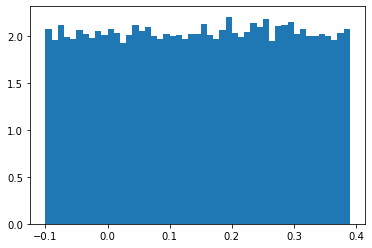

In [11]:
p = plt.hist(ukb_emb.values.ravel(), bins=np.arange(-0.1,0.4,0.01), density=True)

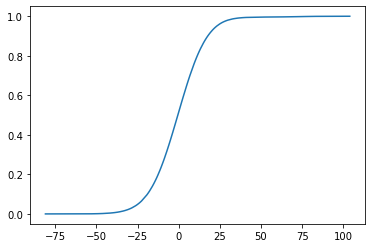

In [12]:
Z = ukb_emb.values.ravel()
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X2, F2)

In [13]:
X2[int(N*0.59)]

2.6659281

In [14]:
len(ukb_emb)

21051

In [15]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)
ukb_positive = ukb_positive.sort_values(ascending=False)

In [16]:
ukb_positive

dim63     1.000000
dim75     0.984466
dim58     0.949836
dim250    0.906370
dim243    0.859627
            ...   
dim13     0.063085
dim153    0.060567
dim56     0.033918
dim102    0.016056
dim166    0.013254
Length: 256, dtype: float64

In [17]:
ukb_positive[10:50]

dim237    0.776068
dim251    0.768230
dim103    0.755356
dim24     0.750226
dim132    0.730559
dim74     0.724574
dim227    0.717828
dim171    0.716783
dim239    0.710988
dim21     0.710988
dim228    0.707377
dim142    0.702864
dim157    0.694884
dim212    0.691416
dim220    0.691321
dim105    0.685811
dim68     0.678495
dim1      0.674315
dim94     0.673982
dim16     0.670372
dim138    0.667949
dim106    0.659209
dim116    0.650895
dim225    0.647665
dim234    0.640540
dim149    0.637452
dim192    0.630659
dim118    0.625576
dim59     0.625243
dim253    0.623011
dim194    0.619781
dim199    0.619591
dim244    0.616550
dim231    0.613178
dim256    0.611040
dim126    0.608902
dim8      0.607382
dim96     0.604579
dim76     0.604532
dim7      0.604342
dtype: float64

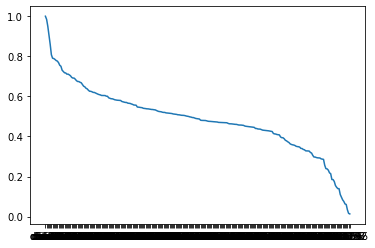

In [18]:
plt.plot(ukb_positive)

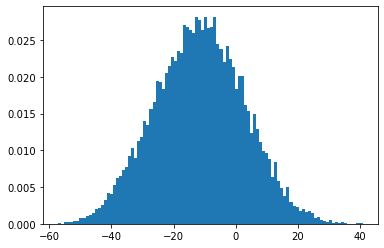

In [19]:
p = plt.hist(ukb_emb.loc[:,"dim83"], bins=100, density=True)

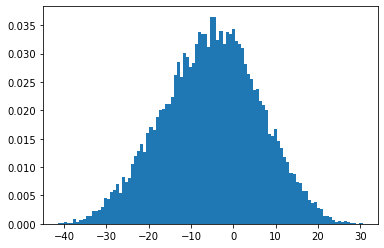

In [20]:
p = plt.hist(ukb_emb.loc[:,"dim65"], bins=100, density=True)

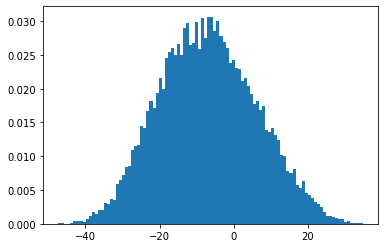

In [21]:
p = plt.hist(ukb_emb.loc[:,"dim188"], bins=100, density=True)

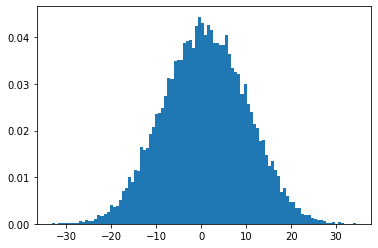

In [22]:
p = plt.hist(ukb_emb.loc[:,"dim10"], bins=100, density=True)

# Schizophrene

In [23]:
# norm = schiz_emb.apply(np.linalg.norm, axis=1)
# schiz_emb = schiz_emb.div(norm, axis=0)

In [24]:
def compute_umap(df, n_neighbors=15):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [25]:
visual_ukb_emb, reducer = compute_umap(ukb_emb, n_neighbors=15)

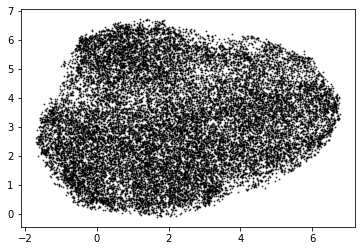

In [26]:
plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c='black', s=1, alpha=0.6)

In [27]:
visual_schiz_emb = reducer.transform(schiz_emb)

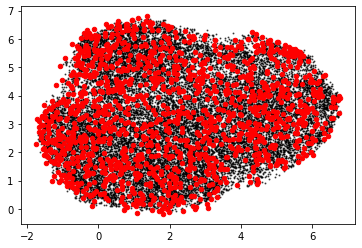

In [28]:
plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c='black', s=1, alpha=0.6)
plt.scatter(visual_schiz_emb[:,0], visual_schiz_emb[:,1], c='red', s=20, alpha=1)

In [29]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)

In [30]:
schiz_order = schiz_emb.copy()
schiz_order.loc["ukb_positive",:] = ukb_positive
schiz_order

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
1,16.921219,8.329333,-5.448877,8.851546,-18.398794,-1.857798,-4.444204,5.968267,-0.268014,13.468454,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
10,7.104989,6.120277,-6.829818,15.520238,-9.423983,2.037611,-9.840734,-1.371655,-4.365594,7.463162,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
101,7.613643,13.741054,-5.458344,18.283995,-11.090379,1.277567,-16.423290,8.620923,-5.829747,4.834498,...,18.414259,-6.979292,-10.903244,2.263794,-3.441388,0.857427,7.599483,0.368111,4.802815,10.747945
102,0.553018,-6.550310,-3.587916,-3.521572,1.106154,0.770448,-1.361575,9.963407,-10.554010,8.540568,...,-0.682740,-16.735806,-5.279205,25.003445,-3.214172,7.829488,8.097090,14.799098,-11.242142,13.689691
103,19.427036,-1.774481,-1.347161,-15.931410,7.620186,-3.841706,7.235090,13.103435,-11.743684,7.171596,...,-2.804867,-1.034834,-3.511542,3.032715,4.006164,-7.770681,6.105875,13.935489,-28.347569,11.506606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-va110289_ses-v1,6.532256,14.376952,5.952120,16.046460,-4.903758,4.059140,0.595604,9.792135,0.489636,4.684096,...,-6.790288,4.971684,-7.461099,25.854273,16.517937,-8.975221,26.504993,-4.094486,29.319670,6.338726
sub-ye110322_ses-v1,-12.242721,2.532474,-0.847486,-12.511105,14.140315,-9.390450,-4.939991,4.159391,11.530051,4.173915,...,-23.518219,-3.301317,-8.264235,24.940355,16.266615,3.291722,10.014540,12.962226,-8.867292,-2.547957
sub-yh100442_ses-v1,4.677122,5.427536,-9.617712,-4.403005,6.549511,-8.480462,6.841185,-4.049585,-30.076952,-9.014664,...,5.489714,-6.599896,2.537030,20.567380,11.013230,-9.769854,-0.253490,15.267757,-24.864496,14.205886


In [31]:
schiz_order = schiz_order.sort_values(schiz_order.last_valid_index(), ascending=False, axis=1)

In [32]:
schiz_order

,dim63,dim75,dim58,dim250,dim243,dim211,dim187,dim104,dim89,dim134,...,dim81,dim53,dim223,dim229,dim109,dim13,dim153,dim56,dim102,dim166
ID,,,,,,,,,,,,,,,,,,,,,
1,71.302160,25.426672,1.639798,14.746664,12.370923,16.036282,1.905336,5.170119,28.650562,20.611223,...,-15.752996,-13.157492,-27.476210,-4.992564,-6.250814,-21.591630,-10.901969,-24.496313,-26.131903,-32.671413
10,64.356094,21.879220,3.192143,2.987553,4.565887,13.433507,2.373449,-5.072914,17.784300,19.585360,...,-20.200712,-9.348351,-14.331278,-7.941752,-17.684105,-17.639252,1.680938,-18.124113,-22.215750,-36.250126
101,70.375760,21.152845,2.288084,2.263794,5.136518,16.081272,0.973202,-7.626207,24.018759,26.080270,...,-22.323153,-10.836150,-13.343608,-10.314510,-17.295729,-13.526638,0.532074,-29.691767,-18.608088,-37.785736
102,90.689026,7.853901,21.316164,25.003445,11.870125,-0.685083,10.787709,7.925241,3.891794,6.967752,...,-12.816909,-21.919836,-28.257814,-30.713955,-18.041298,-15.630749,-21.221294,-20.047205,-27.054802,-52.757100
103,86.215164,12.487788,31.232637,3.032715,12.831666,18.120356,1.703151,2.295102,24.095380,12.113107,...,-5.731476,-9.898081,-15.340723,-26.187933,-17.893272,-4.378776,-43.994225,-41.303640,-20.112200,-34.935993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-va110289_ses-v1,72.395355,43.512283,8.675404,25.854273,7.984988,13.720763,16.187963,36.115260,2.651527,20.633453,...,-15.978116,-34.765770,-28.226137,-19.403303,-6.945932,-33.456257,-5.082605,-29.395178,-29.608090,-31.328020
sub-ye110322_ses-v1,76.955520,26.510803,26.645765,24.940355,14.334578,13.119285,-12.155868,9.361572,7.732681,8.052709,...,6.983947,-39.230537,-9.756817,-22.684023,-20.603487,-42.027245,-25.524479,-12.970994,-20.583464,-45.079807
sub-yh100442_ses-v1,79.040504,22.190489,24.261680,20.567380,13.802206,12.202099,23.549145,-7.660614,2.729470,8.041777,...,-15.754699,-6.381266,3.849388,-41.843937,-36.972332,-14.171974,-22.970242,-38.005570,-36.528100,-43.572680


# Fit on schiz datasets

In [33]:
schiz_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
1,16.921219,8.329333,-5.448877,8.851546,-18.398794,-1.857798,-4.444204,5.968267,-0.268014,13.468454,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
10,7.104989,6.120277,-6.829818,15.520238,-9.423983,2.037611,-9.840734,-1.371655,-4.365594,7.463162,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
101,7.613643,13.741054,-5.458344,18.283995,-11.090379,1.277567,-16.423290,8.620923,-5.829747,4.834498,...,18.414259,-6.979292,-10.903244,2.263794,-3.441388,0.857427,7.599483,0.368111,4.802815,10.747945
102,0.553018,-6.550310,-3.587916,-3.521572,1.106154,0.770448,-1.361575,9.963407,-10.554010,8.540568,...,-0.682740,-16.735806,-5.279205,25.003445,-3.214172,7.829488,8.097090,14.799098,-11.242142,13.689691
103,19.427036,-1.774481,-1.347161,-15.931410,7.620186,-3.841706,7.235090,13.103435,-11.743684,7.171596,...,-2.804867,-1.034834,-3.511542,3.032715,4.006164,-7.770681,6.105875,13.935489,-28.347569,11.506606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-st110288_ses-v1,-12.782913,-5.901133,-1.407924,9.509115,0.308689,16.974428,-4.469516,19.019762,-40.655870,3.016918,...,-4.421456,-3.375361,-3.465752,26.781263,38.450360,-21.703518,-5.671064,6.561089,-7.678912,-1.216511
sub-va110289_ses-v1,6.532256,14.376952,5.952120,16.046460,-4.903758,4.059140,0.595604,9.792135,0.489636,4.684096,...,-6.790288,4.971684,-7.461099,25.854273,16.517937,-8.975221,26.504993,-4.094486,29.319670,6.338726
sub-ye110322_ses-v1,-12.242721,2.532474,-0.847486,-12.511105,14.140315,-9.390450,-4.939991,4.159391,11.530051,4.173915,...,-23.518219,-3.301317,-8.264235,24.940355,16.266615,3.291722,10.014540,12.962226,-8.867292,-2.547957


In [34]:
schiz_all = pd.merge(schiz_label, schiz_emb, left_index=True, right_index=True)

In [35]:
schiz_precatatoes = schiz_all[schiz_all.study=="PreCatatoes"]

In [36]:
d = {'control': 0, "schizophrenia": 1}
train = schiz_all.loc[schiz_all.index.isin(schiz_train[0]),:]
y_train = train['diagnosis'].map(d)
X_train = train.iloc[:, 5:]
val = schiz_all.loc[schiz_all.index.isin(schiz_val[0]),:]
y_val = val['diagnosis'].map(d)
X_val = val.iloc[:, 5:]
test_intra = schiz_all.loc[schiz_all.index.isin(schiz_test_intra[0]),:]
y_test_intra = test_intra['diagnosis'].map(d)
X_test_intra = test_intra.iloc[:, 5:]
test = schiz_all.loc[schiz_all.index.isin(schiz_test[0]),:]
y_test = test['diagnosis'].map(d)
X_test = test.iloc[:, 5:]

In [37]:
train

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas,22.776659,-20.112122,-23.278824,-13.263175,2.919388,...,5.283093,1.119781,4.446758,-9.203698,9.930500,-25.010767,-1.915675,15.065722,-12.242677,11.306650
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas,14.242366,10.703187,-1.354568,26.142553,0.557137,...,-0.246213,-5.605942,-11.164719,4.138003,14.622489,19.126587,15.662466,-8.603357,-18.478380,-5.589627
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas,11.144840,-3.854689,-3.250149,6.490991,-7.623998,...,3.203513,-12.254717,2.737232,20.947224,6.461480,-6.605224,8.185832,-11.064461,3.195110,-3.415207
sub-INV23XFB3ZA,M,25.0,schizophrenia,BSNIP,Dallas,-8.940984,-5.080390,14.049984,-16.278168,21.822144,...,0.413535,0.245769,-13.601363,12.877874,5.227900,-4.797087,9.469066,6.429158,5.791275,14.378581
sub-INV25C66ABC,F,49.0,schizophrenia,BSNIP,Dallas,-6.680430,9.952340,4.298801,-4.944993,4.125648,...,-22.550907,-3.407195,-8.143020,13.955781,21.006330,16.690022,18.442476,3.271532,7.092392,10.385006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-ESOC10090_ses-v1,M,20.0,control,PRAGUE,PRAGUE,15.538490,-1.702526,-3.330036,-11.962825,6.902121,...,2.801665,16.501587,21.078566,16.973345,5.557261,-14.078880,-4.925864,7.007492,-12.346126,-5.556739
sub-ESOC10060_ses-v1,F,26.0,control,PRAGUE,PRAGUE,10.097585,-7.820383,13.164856,12.372369,-13.540027,...,-16.430481,-5.618235,-26.517231,13.862317,31.963438,-10.839795,21.892687,7.311578,15.485500,-6.460208
sub-ESOC10019_ses-v1,F,28.0,control,PRAGUE,PRAGUE,37.759712,9.583571,1.169959,24.848183,-32.224010,...,25.259438,-15.705032,3.945574,8.563596,1.668106,-3.254404,5.355773,18.336996,-4.336146,9.774138
sub-ESOC10063_ses-v1,M,31.0,control,PRAGUE,PRAGUE,3.185014,-7.156518,-16.974295,-3.074156,4.911406,...,-11.896551,-2.772561,9.636458,8.613264,29.251406,-10.146291,10.662353,29.607990,-4.974310,-2.267846


In [38]:
X_train.shape

(903, 256)

In [39]:
bst = XGBClassifier(max_depth=1, min_child_weight=5, alpha=1, learning_rate=0.001, objective='binary:logistic')

In [40]:
X_train.shape

(903, 256)

In [41]:
y_train.shape

(903,)

In [42]:
bst.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
roc_auc_score(y_train, bst.predict_proba(X_train)[:,1])

0.5993048836380303

In [44]:
roc_auc_score(y_val, bst.predict_proba(X_val)[:,1])

0.49754901960784315

In [45]:
roc_auc_score(y_test_intra, bst.predict_proba(X_test_intra)[:,1])

0.5339869281045752

In [46]:
roc_auc_score(y_test, bst.predict_proba(X_test)[:,1])

0.4757601835915089

In [47]:
param_grid = {
    'max_depth': [1],
    'learning_rate': [0.0001],
    'subsample': [0.2]
}

In [48]:
split_index = [-1]*len(X_train) + [0]*len(X_val)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

In [49]:
X.shape

(1016, 256)

In [50]:
# Grid-search all parameter combinations using a validation set.
opt = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic'), cv=pds, param_grid = param_grid)
opt.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.0001], 'max_depth': [1],
                         'subsample': [0.2]})

In [51]:
roc_auc_score(y_train, opt.best_estimator_.predict_proba(X_train)[:,1])

0.641055150990477

In [52]:
roc_auc_score(y_val, opt.best_estimator_.predict_proba(X_val)[:,1])

0.5852941176470589

In [53]:
roc_auc_score(y_test_intra, opt.best_estimator_.predict_proba(X_test_intra)[:,1])

0.5199346405228757

In [54]:
roc_auc_score(y_test, opt.best_estimator_.predict_proba(X_test)[:,1])

0.4953897221539218

In [55]:
opt.best_params_

{'learning_rate': 0.0001, 'max_depth': 1, 'subsample': 0.2}

# UMAP

In [56]:
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,1.497522,-17.298222,-7.023603,-11.205885,14.206353,-8.073137,12.077803,1.188005,-21.182160,12.422483,...,-0.782009,-13.568072,11.335606,27.711756,1.055951,16.339926,-6.282044,17.143698,-42.953117,-9.542476
sub-1000458,-3.609246,11.989327,3.261152,-24.368643,17.229946,-15.242127,18.376665,5.099380,-12.348334,1.510425,...,-5.986905,5.410737,-0.495618,18.814777,-1.137268,-2.769095,-3.145500,-1.589806,-26.272230,19.650710
sub-1000575,9.973359,-0.526970,-16.491266,-6.800225,13.853608,-1.892061,12.505042,25.941790,20.332819,6.928286,...,-10.767097,8.413599,1.047728,5.613638,4.589878,5.264478,-3.590338,-26.656113,3.834120,-3.502216
sub-1000606,38.929436,5.370797,8.908671,10.817114,-36.351353,5.951402,-3.859577,19.411158,-6.009777,8.619954,...,-10.831139,4.726006,-3.820110,15.025682,16.366623,-1.969968,30.462904,10.683294,9.435775,28.027756
sub-1000963,36.624977,6.796172,28.739016,-24.772793,-1.008246,-18.348162,12.348809,0.414275,-4.930811,8.232450,...,-3.167979,20.949572,14.828034,14.677424,1.205625,10.694344,7.305981,6.147270,-15.829991,2.581371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,13.933055,-2.528124,13.587676,13.413878,-1.649166,6.557288,6.679683,4.042784,-5.927331,-2.414733,...,-3.064186,6.123437,1.346105,23.049840,17.548922,6.431029,4.111210,-13.984839,8.037389,-27.171171
sub-6023808,2.091982,-9.837544,-9.529078,1.424691,3.072437,2.858213,11.038856,-8.540625,1.723715,-6.049696,...,-19.180178,3.726936,2.863255,20.683193,26.914165,-17.799795,-2.707847,-6.360041,-4.336803,-9.629988
sub-6023847,21.655308,1.412237,-10.311806,4.494585,1.016458,5.328015,14.061031,6.532976,-20.227161,11.678906,...,-0.438347,3.516693,2.250516,42.720130,-2.343096,4.778626,8.819581,-1.611091,-7.671606,2.956114


In [57]:
train

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas,22.776659,-20.112122,-23.278824,-13.263175,2.919388,...,5.283093,1.119781,4.446758,-9.203698,9.930500,-25.010767,-1.915675,15.065722,-12.242677,11.306650
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas,14.242366,10.703187,-1.354568,26.142553,0.557137,...,-0.246213,-5.605942,-11.164719,4.138003,14.622489,19.126587,15.662466,-8.603357,-18.478380,-5.589627
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas,11.144840,-3.854689,-3.250149,6.490991,-7.623998,...,3.203513,-12.254717,2.737232,20.947224,6.461480,-6.605224,8.185832,-11.064461,3.195110,-3.415207
sub-INV23XFB3ZA,M,25.0,schizophrenia,BSNIP,Dallas,-8.940984,-5.080390,14.049984,-16.278168,21.822144,...,0.413535,0.245769,-13.601363,12.877874,5.227900,-4.797087,9.469066,6.429158,5.791275,14.378581
sub-INV25C66ABC,F,49.0,schizophrenia,BSNIP,Dallas,-6.680430,9.952340,4.298801,-4.944993,4.125648,...,-22.550907,-3.407195,-8.143020,13.955781,21.006330,16.690022,18.442476,3.271532,7.092392,10.385006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-ESOC10090_ses-v1,M,20.0,control,PRAGUE,PRAGUE,15.538490,-1.702526,-3.330036,-11.962825,6.902121,...,2.801665,16.501587,21.078566,16.973345,5.557261,-14.078880,-4.925864,7.007492,-12.346126,-5.556739
sub-ESOC10060_ses-v1,F,26.0,control,PRAGUE,PRAGUE,10.097585,-7.820383,13.164856,12.372369,-13.540027,...,-16.430481,-5.618235,-26.517231,13.862317,31.963438,-10.839795,21.892687,7.311578,15.485500,-6.460208
sub-ESOC10019_ses-v1,F,28.0,control,PRAGUE,PRAGUE,37.759712,9.583571,1.169959,24.848183,-32.224010,...,25.259438,-15.705032,3.945574,8.563596,1.668106,-3.254404,5.355773,18.336996,-4.336146,9.774138
sub-ESOC10063_ses-v1,M,31.0,control,PRAGUE,PRAGUE,3.185014,-7.156518,-16.974295,-3.074156,4.911406,...,-11.896551,-2.772561,9.636458,8.613264,29.251406,-10.146291,10.662353,29.607990,-4.974310,-2.267846


In [58]:
train.iloc[:,5:]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-INV07WT2ZL3,22.776659,-20.112122,-23.278824,-13.263175,2.919388,1.443668,3.859253,-3.729118,5.654493,12.925337,...,5.283093,1.119781,4.446758,-9.203698,9.930500,-25.010767,-1.915675,15.065722,-12.242677,11.306650
sub-INV0AL14J6U,14.242366,10.703187,-1.354568,26.142553,0.557137,-1.449915,-5.088081,19.675459,-20.537950,0.873500,...,-0.246213,-5.605942,-11.164719,4.138003,14.622489,19.126587,15.662466,-8.603357,-18.478380,-5.589627
sub-INV14XK7P6E,11.144840,-3.854689,-3.250149,6.490991,-7.623998,3.702620,21.953808,3.635944,-13.486443,-8.295109,...,3.203513,-12.254717,2.737232,20.947224,6.461480,-6.605224,8.185832,-11.064461,3.195110,-3.415207
sub-INV23XFB3ZA,-8.940984,-5.080390,14.049984,-16.278168,21.822144,-3.248714,7.011268,14.690064,-10.217360,2.493177,...,0.413535,0.245769,-13.601363,12.877874,5.227900,-4.797087,9.469066,6.429158,5.791275,14.378581
sub-INV25C66ABC,-6.680430,9.952340,4.298801,-4.944993,4.125648,-9.767530,-15.963885,31.438572,8.442224,11.529752,...,-22.550907,-3.407195,-8.143020,13.955781,21.006330,16.690022,18.442476,3.271532,7.092392,10.385006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-ESOC10090_ses-v1,15.538490,-1.702526,-3.330036,-11.962825,6.902121,-8.327404,17.464968,-8.565586,-2.005353,24.251009,...,2.801665,16.501587,21.078566,16.973345,5.557261,-14.078880,-4.925864,7.007492,-12.346126,-5.556739
sub-ESOC10060_ses-v1,10.097585,-7.820383,13.164856,12.372369,-13.540027,22.017508,-16.030610,38.197260,-10.879383,1.641790,...,-16.430481,-5.618235,-26.517231,13.862317,31.963438,-10.839795,21.892687,7.311578,15.485500,-6.460208
sub-ESOC10019_ses-v1,37.759712,9.583571,1.169959,24.848183,-32.224010,-8.482738,-17.925620,-8.348042,-12.597330,-11.995513,...,25.259438,-15.705032,3.945574,8.563596,1.668106,-3.254404,5.355773,18.336996,-4.336146,9.774138
sub-ESOC10063_ses-v1,3.185014,-7.156518,-16.974295,-3.074156,4.911406,-14.930636,-18.241796,-14.164924,17.204144,4.429974,...,-11.896551,-2.772561,9.636458,8.613264,29.251406,-10.146291,10.662353,29.607990,-4.974310,-2.267846


In [59]:
schiz_precatatoes

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,-18.398794,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,-9.423983,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,-1.152447,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,-10.008460,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,-9.423983,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,-8.613283,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,19.067230,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,6.530913,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,7.134831,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [60]:
reducer = UMAP()
umap_ukb = reducer.fit_transform(ukb_emb)

In [166]:
schiz_all

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas,22.776659,-20.112122,-23.278824,-13.263175,2.919388,...,5.283093,1.119781,4.446758,-9.203698,9.930500,-25.010767,-1.915675,15.065722,-12.242677,11.306650
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas,14.242366,10.703187,-1.354568,26.142553,0.557137,...,-0.246213,-5.605942,-11.164719,4.138003,14.622489,19.126587,15.662466,-8.603357,-18.478380,-5.589627
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas,11.144840,-3.854689,-3.250149,6.490991,-7.623998,...,3.203513,-12.254717,2.737232,20.947224,6.461480,-6.605224,8.185832,-11.064461,3.195110,-3.415207
sub-INV1HXNTXYF,F,18.0,control,BSNIP,Dallas,-6.870567,-1.088737,0.996183,12.330552,7.867712,...,3.465343,-6.894920,-4.595478,0.402408,37.935760,-9.983110,8.009443,14.631487,10.880589,-15.929758
sub-INV1XCNF4J5,F,25.0,control,BSNIP,Dallas,-4.440757,-12.071540,-4.352410,7.769451,0.494602,...,-3.127630,-24.389639,-8.232522,-3.373587,27.853634,-4.304760,0.264949,0.343576,-12.453900,-16.594442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,-8.613283,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,19.067230,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,6.530913,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,7.134831,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [167]:
umap_schiz_all = reducer.transform(schiz_all.iloc[:, 5:])

In [61]:
umap_schiz = reducer.transform(train.iloc[:, 5:])

In [62]:
umap_precatatoes = reducer.transform(schiz_precatatoes.iloc[:, 5:])

In [63]:
umap_ukb.shape

(21051, 2)

In [64]:
cmap = {'control':'b', 'schizophrenia':'r'}
colors = [cmap[diag] for diag in train.diagnosis]
colors_precatatoes = [cmap[diag] for diag in schiz_precatatoes.diagnosis]

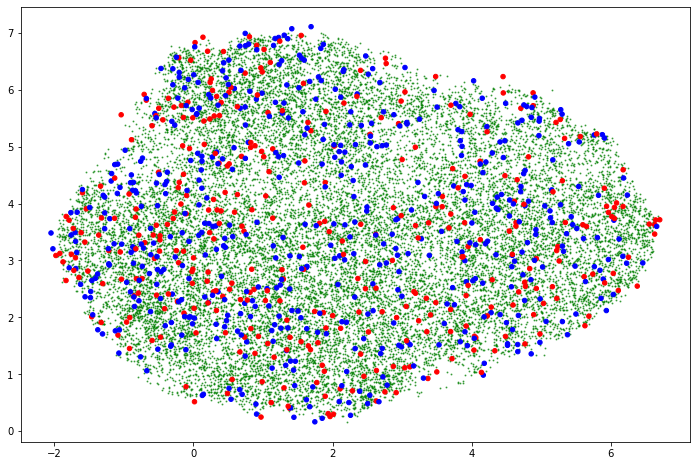

In [65]:
plt.figure(figsize=(12,8))
plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_schiz[:,0], umap_schiz[:,1], s=20, c=colors, alpha=1)
plt.show()

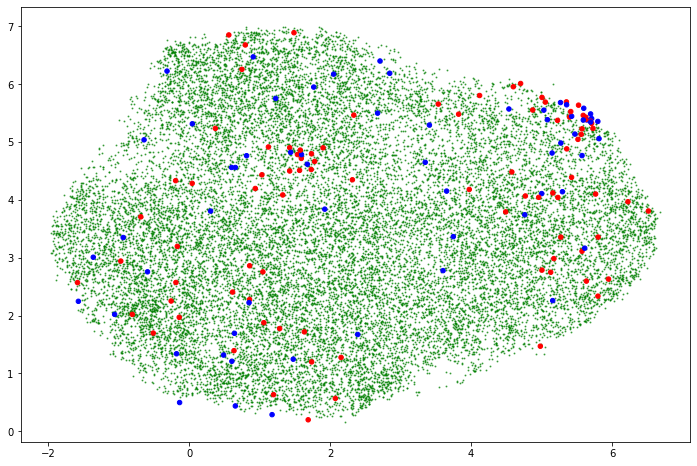

In [66]:
plt.figure(figsize=(12,8))
plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_precatatoes[:,0], umap_precatatoes[:,1], s=20, c=colors_precatatoes, alpha=1)
plt.show()

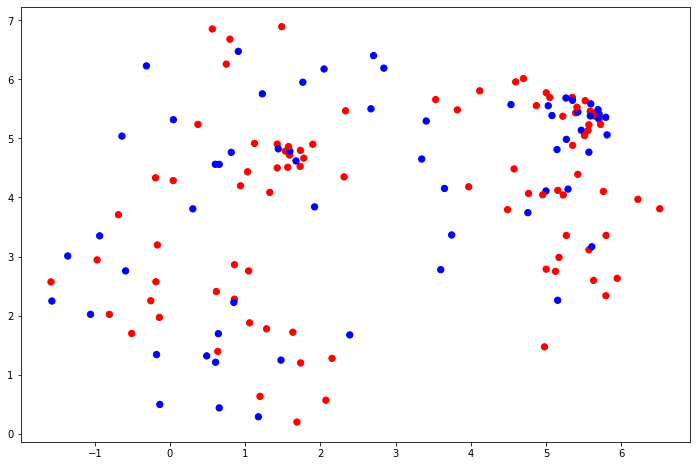

In [67]:
plt.figure(figsize=(12,8))
# plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_precatatoes[:,0], umap_precatatoes[:,1], s=40, c=colors_precatatoes, alpha=1)
plt.show()

In [68]:
precatatoes_labels = pd.read_csv(precatatoes_file, dtype={'participant_id':str})[["participant_id", "catatonie"]]
precatatoes_labels.set_index("participant_id", inplace=True)

In [69]:
precatatoes_all = pd.read_csv(precatatoes_file, dtype={'participant_id':str})[['participant_id', 'type_OFC_G']]
precatatoes_all.set_index("participant_id", inplace=True)
precatatoes_all

,type_OFC_G
participant_id,
1,III
2,III
3,I
4,II
5,III
...,...
182,III
183,III
184,I


In [70]:
precatatoes_labels.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '176', '178', '179', '180', '181', '182', '183', '184', '185', '186'],
      dtype='object', name='participant_id', length=162)

In [71]:
schiz_precatatoes.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '175', '176', '178', '179', '181', '182', '183', '184', '185', '186'],
      dtype='object', length=150)

In [72]:
schiz_precatatoes_cat = pd.merge(precatatoes_labels, schiz_precatatoes, left_index=True, right_index=True)

In [73]:
schiz_precatatoes_pattern = pd.merge(precatatoes_all, schiz_precatatoes, left_index=True, right_index=True)
schiz_precatatoes_pattern

,type_OFC_G,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,III,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,III,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,I,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,II,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,III,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,III,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,III,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,I,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,I,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [74]:
schiz_precatatoes_cat = schiz_precatatoes_cat[schiz_precatatoes_cat.diagnosis=="schizophrenia"]

In [75]:
schiz_precatatoes_cat

,catatonie,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,oui,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,oui,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,non,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,non,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,oui,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,non,M,57.0,schizophrenia,PreCatatoes,Sainte-Anne,-1.973624,8.443038,10.777081,18.940794,...,7.068343,0.548816,-25.265984,3.793471,3.835645,-7.033398,7.000394,-3.906946,8.134303,-4.250280
182,non,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,non,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
185,oui,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [76]:
cmap = {'non':'b', 'oui':'r'}
colors_catatonie = [cmap[diag] for diag in schiz_precatatoes_cat.catatonie]

In [77]:
umap_cat = reducer.transform(schiz_precatatoes_cat.iloc[:, 6:])

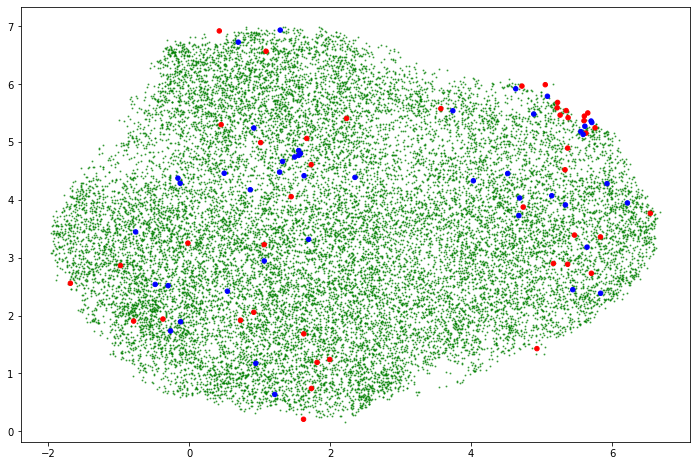

In [78]:
plt.figure(figsize=(12,8))
plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_cat[:,0], umap_cat[:,1], s=20, c=colors_catatonie, alpha=1)
plt.show()

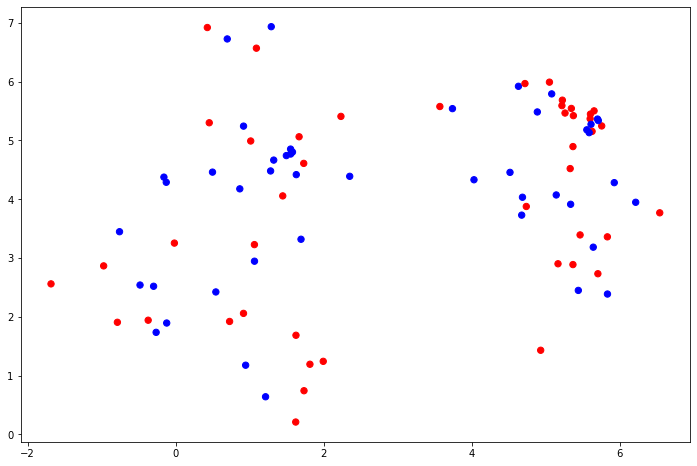

In [79]:
plt.figure(figsize=(12,8))
# plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_cat[:,0], umap_cat[:,1], s=40, c=colors_catatonie, alpha=1)
plt.show()

In [80]:
schiz_precatatoes_pattern.iloc[:, 6:]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,16.921219,8.329333,-5.448877,8.851546,-18.398794,-1.857798,-4.444204,5.968267,-0.268014,13.468454,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,7.104989,6.120277,-6.829818,15.520238,-9.423983,2.037611,-9.840734,-1.371655,-4.365594,7.463162,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,6.600823,6.963279,-11.671963,15.169384,-1.152447,-0.397565,-6.763300,-1.186566,-12.565821,10.193141,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,6.555328,5.550172,-6.011322,15.547208,-10.008460,2.839864,-11.440421,0.087390,-2.536862,5.972901,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,7.104989,6.120277,-6.829818,15.520238,-9.423983,2.037611,-9.840734,-1.371655,-4.365594,7.463162,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,8.874130,14.131187,-3.530384,20.666506,-8.613283,3.262477,-23.710247,11.366632,-7.308549,7.029092,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,0.635610,8.346911,11.597758,-11.799322,19.067230,-6.854317,5.361399,-7.083338,21.154760,-9.744535,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,7.086482,-16.808205,15.648663,-31.961168,6.530913,-7.427599,14.448416,9.861704,0.136980,-8.186386,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,-4.517472,5.601651,1.674870,6.962694,7.134831,5.937163,-6.600293,6.860873,-11.937251,1.476205,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [81]:
reducer_cat = UMAP()
reducer_cat.fit(schiz_precatatoes_pattern.iloc[:, 6:])
umap_cat2 = reducer_cat.transform(schiz_precatatoes_cat.iloc[:, 6:])
umap_pat2 = reducer_cat.transform(schiz_precatatoes_pattern.iloc[:, 6:])

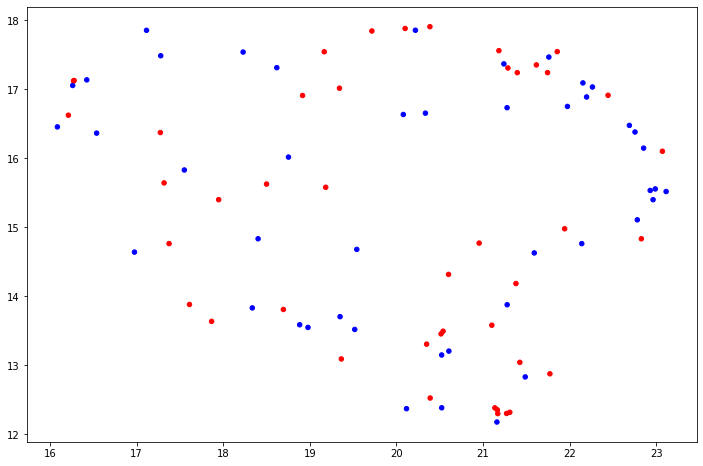

In [82]:
plt.figure(figsize=(12,8))
plt.scatter(umap_cat2[:,0], umap_cat2[:,1], s=20, c=colors_catatonie, alpha=1)
plt.show()

In [83]:
len(umap_cat2)

89

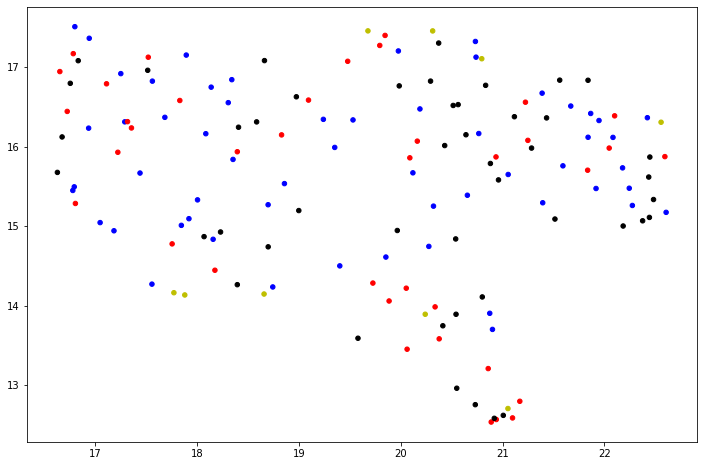

In [84]:
plt.figure(figsize=(12,8))
cmap = {'I':'b', 'II':'black', 'III': 'r', 'IV': 'y'}
colors_pattern = [cmap[diag] for diag in schiz_precatatoes_pattern.type_OFC_G]
plt.scatter(umap_pat2[:,0], umap_pat2[:,1], s=20, c=colors_pattern, alpha=1)
plt.show()

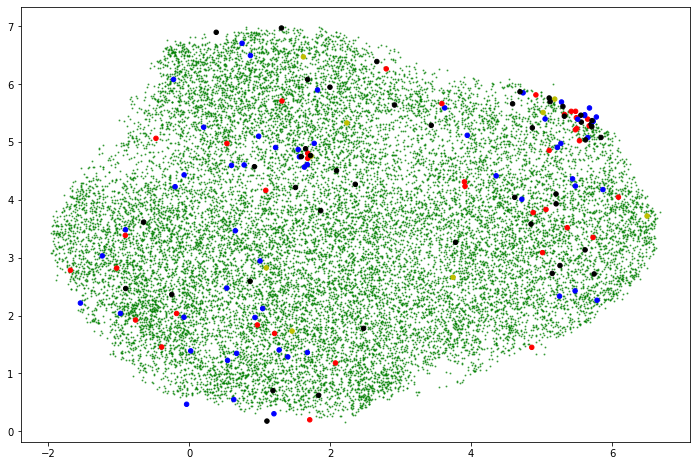

In [85]:
plt.figure(figsize=(12,8))
cmap = {'I':'b', 'II':'black', 'III': 'r', 'IV': 'y'}
umap_pat = reducer.transform(schiz_precatatoes_pattern.iloc[:, 6:])
colors_pattern = [cmap[diag] for diag in schiz_precatatoes_pattern.type_OFC_G]
plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_pat[:,0], umap_pat[:,1], s=20, c=colors_pattern, alpha=1)
plt.show()

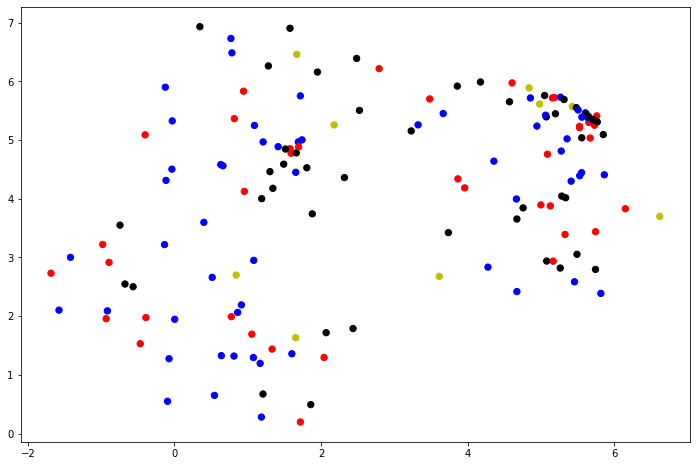

In [86]:
plt.figure(figsize=(12,8))
cmap = {'I':'b', 'II':'black', 'III': 'r', 'IV': 'y'}
umap_pat = reducer.transform(schiz_precatatoes_pattern.iloc[:, 6:])
colors_pattern = [cmap[diag] for diag in schiz_precatatoes_pattern.type_OFC_G]
# plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=1, c='green', alpha=0.6)
plt.scatter(umap_pat[:,0], umap_pat[:,1], s=40, c=colors_pattern, alpha=1)
plt.show()

In [87]:
schiz_precatatoes

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,-18.398794,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,-9.423983,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,-1.152447,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,-10.008460,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,-9.423983,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,-8.613283,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,19.067230,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,6.530913,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,7.134831,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [88]:
classifier = SVC(kernel='linear', probability=True,
        max_iter=-1,
        C=0.01, class_weight='balanced', decision_function_shape='ovr')
classifier.fit(schiz_precatatoes_cat.iloc[:, 6:], schiz_precatatoes_cat.iloc[:, 0])

# cross_val_score(classifier, schiz_precatatoes_cat.iloc[:, 6:], schiz_precatatoes_cat.iloc[:, 0], cv=5)

SVC(C=0.01, class_weight='balanced', kernel='linear', probability=True)

In [89]:
schiz_precatatoes_cat

,catatonie,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,oui,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,oui,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,non,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,non,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,oui,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,non,M,57.0,schizophrenia,PreCatatoes,Sainte-Anne,-1.973624,8.443038,10.777081,18.940794,...,7.068343,0.548816,-25.265984,3.793471,3.835645,-7.033398,7.000394,-3.906946,8.134303,-4.250280
182,non,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,non,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
185,oui,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [90]:
roc_auc_score(schiz_precatatoes_cat.iloc[:, 0].map({"non": 0, "oui": 1}), classifier.predict_proba(schiz_precatatoes_cat.iloc[:, 6:])[:,1])

0.9143939393939393

In [91]:
schiz_precatatoes_cat.iloc[:, 0].map({"non": 0, "oui": 1}).unique()

array([1, 0])

In [92]:
scores = cross_val_score(classifier,
                schiz_precatatoes_cat.iloc[:, 6:],
                schiz_precatatoes_cat.iloc[:, 0].map({"non": 0, "oui": 1}),
                scoring='roc_auc', cv=3)
print(np.mean(scores), np.std(scores))

0.4357671957671958 0.055014040113532794


In [93]:
schiz_precatatoes_cat.iloc[:, 0].map({"non": 0, "oui": 1})

1      1
2      1
3      0
4      0
5      1
      ..
171    0
182    0
183    0
185    1
186    1
Name: catatonie, Length: 89, dtype: int64

In [96]:
schiz_precatatoes_pattern

,type_OFC_G,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
1,III,M,63.0,schizophrenia,PreCatatoes,Sainte-Anne,16.921219,8.329333,-5.448877,8.851546,...,18.496199,-2.371990,6.067088,14.746664,-9.268885,5.467108,3.023819,-0.725356,7.552559,10.527573
2,III,M,45.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
3,I,M,26.0,schizophrenia,PreCatatoes,Sainte-Anne,6.600823,6.963279,-11.671963,15.169384,...,19.194597,-6.434347,-8.195658,8.744914,-4.958701,-1.096409,7.570299,6.515043,-6.125521,7.428402
4,II,F,68.0,schizophrenia,PreCatatoes,Sainte-Anne,6.555328,5.550172,-6.011322,15.547208,...,14.534529,-8.010104,-2.003866,2.890215,-2.738020,-0.520391,2.754013,1.613638,3.781825,1.826595
5,III,F,48.0,schizophrenia,PreCatatoes,Sainte-Anne,7.104989,6.120277,-6.829818,15.520238,...,15.086761,-7.725659,-1.283426,2.987553,-4.268246,-0.267787,3.714170,2.213987,1.453220,2.437245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,III,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,III,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,I,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,I,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [98]:
# classifier = SVC(kernel='linear', probability=True,
#         max_iter=-1,
#         C=0.01, class_weight='balanced', decision_function_shape='ovr')
# scores = cross_val_score(classifier,
#                 schiz_precatatoes_pattern.iloc[:, 6:],
#                 schiz_precatatoes_pattern.iloc[:, 0].map({"I": 0, "II": 1, "III": 2, "IV": 3}),
#                 scoring='roc_auc', cv=3)
# print(np.mean(scores), np.std(scores))

In [101]:
# encoder.fit_transform(schiz_precatatoes_pattern.iloc[:, [0]]).toarray().shape

# UKB latent space analysis

In [102]:
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,1.497522,-17.298222,-7.023603,-11.205885,14.206353,-8.073137,12.077803,1.188005,-21.182160,12.422483,...,-0.782009,-13.568072,11.335606,27.711756,1.055951,16.339926,-6.282044,17.143698,-42.953117,-9.542476
sub-1000458,-3.609246,11.989327,3.261152,-24.368643,17.229946,-15.242127,18.376665,5.099380,-12.348334,1.510425,...,-5.986905,5.410737,-0.495618,18.814777,-1.137268,-2.769095,-3.145500,-1.589806,-26.272230,19.650710
sub-1000575,9.973359,-0.526970,-16.491266,-6.800225,13.853608,-1.892061,12.505042,25.941790,20.332819,6.928286,...,-10.767097,8.413599,1.047728,5.613638,4.589878,5.264478,-3.590338,-26.656113,3.834120,-3.502216
sub-1000606,38.929436,5.370797,8.908671,10.817114,-36.351353,5.951402,-3.859577,19.411158,-6.009777,8.619954,...,-10.831139,4.726006,-3.820110,15.025682,16.366623,-1.969968,30.462904,10.683294,9.435775,28.027756
sub-1000963,36.624977,6.796172,28.739016,-24.772793,-1.008246,-18.348162,12.348809,0.414275,-4.930811,8.232450,...,-3.167979,20.949572,14.828034,14.677424,1.205625,10.694344,7.305981,6.147270,-15.829991,2.581371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,13.933055,-2.528124,13.587676,13.413878,-1.649166,6.557288,6.679683,4.042784,-5.927331,-2.414733,...,-3.064186,6.123437,1.346105,23.049840,17.548922,6.431029,4.111210,-13.984839,8.037389,-27.171171
sub-6023808,2.091982,-9.837544,-9.529078,1.424691,3.072437,2.858213,11.038856,-8.540625,1.723715,-6.049696,...,-19.180178,3.726936,2.863255,20.683193,26.914165,-17.799795,-2.707847,-6.360041,-4.336803,-9.629988
sub-6023847,21.655308,1.412237,-10.311806,4.494585,1.016458,5.328015,14.061031,6.532976,-20.227161,11.678906,...,-0.438347,3.516693,2.250516,42.720130,-2.343096,4.778626,8.819581,-1.611091,-7.671606,2.956114


In [104]:
global_id = skdim.id.MOM().fit(ukb_emb)

In [106]:
global_id.dimension_

11.832918289660157

In [109]:
# lid_mom = skdim.id.lPCA().fit_pw(ukb_emb, n_neighbors=50, n_jobs=1)

In [111]:
# lid_mom.dimension_

16

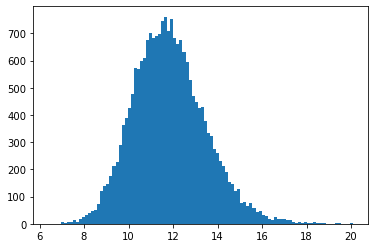

In [117]:

h = plt.hist(global_id.dimension_pw_, bins=100)

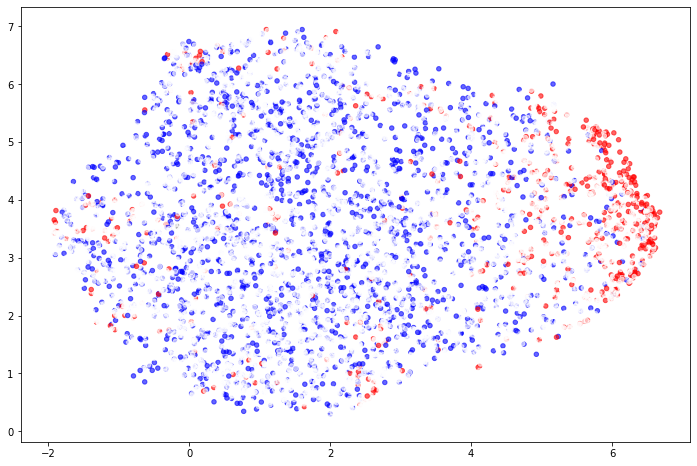

In [158]:
plt.figure(figsize=(12,8))
cmap, norm = mcolors.from_levels_and_colors([0, 9, 14, 20], ['red', 'white', 'blue'])
alpha = []
plt.scatter(umap_ukb[:,0], umap_ukb[:,1], s=20, c=global_id.dimension_pw_, alpha=0.6, cmap=cmap, norm=norm)
plt.show()

In [159]:
schiz_all

,sex,age,diagnosis,study,site,dim1,dim2,dim3,dim4,dim5,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas,22.776659,-20.112122,-23.278824,-13.263175,2.919388,...,5.283093,1.119781,4.446758,-9.203698,9.930500,-25.010767,-1.915675,15.065722,-12.242677,11.306650
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas,14.242366,10.703187,-1.354568,26.142553,0.557137,...,-0.246213,-5.605942,-11.164719,4.138003,14.622489,19.126587,15.662466,-8.603357,-18.478380,-5.589627
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas,11.144840,-3.854689,-3.250149,6.490991,-7.623998,...,3.203513,-12.254717,2.737232,20.947224,6.461480,-6.605224,8.185832,-11.064461,3.195110,-3.415207
sub-INV1HXNTXYF,F,18.0,control,BSNIP,Dallas,-6.870567,-1.088737,0.996183,12.330552,7.867712,...,3.465343,-6.894920,-4.595478,0.402408,37.935760,-9.983110,8.009443,14.631487,10.880589,-15.929758
sub-INV1XCNF4J5,F,25.0,control,BSNIP,Dallas,-4.440757,-12.071540,-4.352410,7.769451,0.494602,...,-3.127630,-24.389639,-8.232522,-3.373587,27.853634,-4.304760,0.264949,0.343576,-12.453900,-16.594442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,8.874130,14.131187,-3.530384,20.666506,-8.613283,...,14.669910,-4.588848,-15.147165,-3.078043,0.181961,-1.342840,8.805179,4.840029,0.044579,8.623668
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,0.635610,8.346911,11.597758,-11.799322,19.067230,...,-11.850937,10.586857,-11.376975,1.813701,4.901993,-21.840601,4.486218,-4.111508,8.143082,11.819787
184,M,26.0,control,PreCatatoes,Sainte-Anne,7.086482,-16.808205,15.648663,-31.961168,6.530913,...,-16.883736,6.920692,-1.414432,21.865520,17.578250,-0.539707,2.201438,5.801393,-7.740819,-1.098766
185,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,-4.517472,5.601651,1.674870,6.962694,7.134831,...,11.667326,-8.618561,-18.164635,5.035779,-4.672620,-7.646978,5.416160,0.057126,3.901223,11.117148


In [160]:
schiz_id = skdim.id.MOM().fit(schiz_all.iloc[:,5:])

In [161]:
schiz_id.dimension_

10.472666516109037

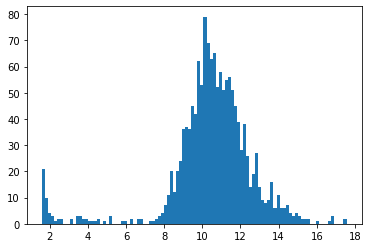

In [162]:
h = plt.hist(schiz_id.dimension_pw_, bins=100)

In [165]:
schiz_all.shape

(1442, 261)

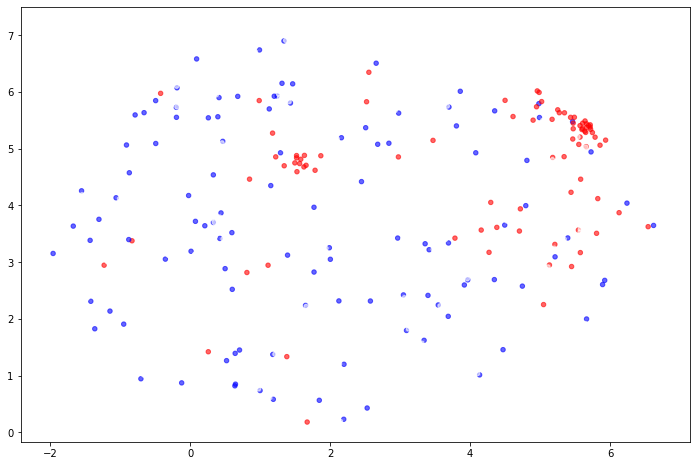

In [169]:
plt.figure(figsize=(12,8))
cmap, norm = mcolors.from_levels_and_colors([0, 8, 13, 20], ['red', 'white', 'blue'])
alpha = []
plt.scatter(umap_schiz_all[:,0], umap_schiz_all[:,1], s=20, c=schiz_id.dimension_pw_, alpha=0.6, cmap=cmap, norm=norm)
plt.show()

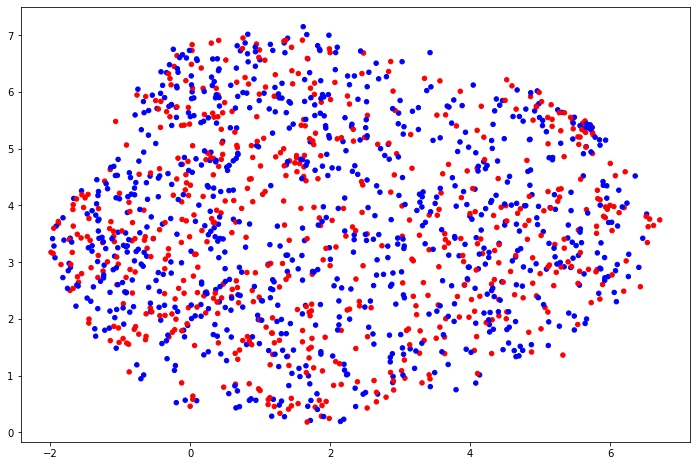

In [170]:
cmap = {'control':'b', 'schizophrenia':'r'}
colors = [cmap[diag] for diag in schiz_all.diagnosis]
plt.figure(figsize=(12,8))
plt.scatter(umap_schiz_all[:,0], umap_schiz_all[:,1], s=20, c=colors, alpha=1)
plt.show()

In [172]:
schiz_id.dimension_pw_.shape

(1442,)

In [174]:
schiz_all_id = schiz_all.iloc[:,0:5]

In [178]:
schiz_all_id["id"] = schiz_id.dimension_pw_

In [184]:
schiz_all_id

,sex,age,diagnosis,study,site,id
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas,9.992941
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas,10.733856
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas,10.818193
sub-INV1HXNTXYF,F,18.0,control,BSNIP,Dallas,8.316397
sub-INV1XCNF4J5,F,25.0,control,BSNIP,Dallas,10.471978
...,...,...,...,...,...,...
182,M,53.0,schizophrenia,PreCatatoes,Sainte-Anne,2.004392
183,F,19.0,schizophrenia,PreCatatoes,Sainte-Anne,10.920825
184,M,26.0,control,PreCatatoes,Sainte-Anne,10.173594
185,M,29.0,schizophrenia,PreCatatoes,Sainte-Anne,3.871264


<AxesSubplot:xlabel='id', ylabel='Proportion'>

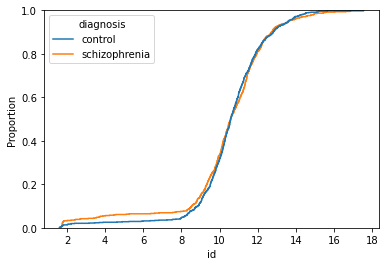

In [187]:
sns.ecdfplot(data=schiz_all_id, x="id", hue="diagnosis")

<AxesSubplot:xlabel='id', ylabel='Proportion'>

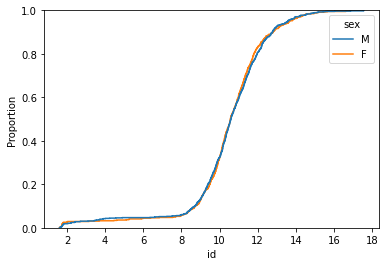

In [188]:
sns.ecdfplot(data=schiz_all_id, x="id", hue="sex")